In [3]:
import math
import numpy as np

from IPython.display import Audio
from scipy.io import wavfile
import random

In [4]:
class Oscillator:
    def __init__(self, freq, phase=0):
        self.freq = freq
        self.phase = phase
        self.cur_phase = 0
        self.phase_step = 0
    
    def set_phase_step(self, phase_step):
        self.phase_step = phase_step

    def step(self):
        self.cur_phase += self.phase_step
        if self.cur_phase >= 2 * math.pi:
            self.cur_phase -= 2 * math.pi
        return math.sin(self.cur_phase)

In [5]:
sample_rate = 12000
fsk_base_freq = 300
fsk_freq_diff = 500
fsk_symbol_duration = sample_rate//10

def fsk_modulate(data):
    wav = []
    osc = Oscillator(0)
    for _ in range(random.randint(1, fsk_symbol_duration)):
        wav.append(osc.step())
    for i in range(len(data)):
        freq = fsk_base_freq + fsk_freq_diff * data[i]
        
        osc.set_phase_step(2 * math.pi * freq / sample_rate)
        for _ in range(fsk_symbol_duration):
            wav.append(osc.step())
    for _ in range(random.randint(1, fsk_symbol_duration)):
        wav.append(osc.step())
    return np.array(wav)

In [6]:
def to_wav(symbols, wav_file):
    wav = fsk_modulate(symbols)
    # Add AWGN of 0.001 amplitude
    wav += 0.001 * np.random.randn(len(wav))
    wav = (wav * 32767 / 4).astype(np.int16)
    wavfile.write(wav_file, sample_rate, wav)

In [7]:
def hamming(bits):
    p1 = bits[0] ^ bits[1] ^ bits[3]
    p2 = bits[0] ^ bits[2] ^ bits[3]
    p3 = bits[1] ^ bits[2] ^ bits[3]
    return [p1, p2, bits[0], p3, bits[1], bits[2], bits[3]]

def str_to_symbols(s, has_errors=False):
    symbols = []
    for c in s:
        num = ord(c)
        bits = [0] * 8
        for i in range(8):
            bits[i] = num % 2
            num //= 2
        hamming_bits = hamming(bits[:4])
        if has_errors and random.random() < 0.8:
            hamming_bits[random.randint(0, 6)] ^= 1
        symbols += hamming_bits
        hamming_bits = hamming(bits[4:])
        if has_errors and random.random() < 0.8:
            hamming_bits[random.randint(0, 6)] ^= 1
        symbols += hamming_bits
        
    return symbols

In [17]:
to_wav(str_to_symbols('greyhats'), 'greyhats.wav')
to_wav(str_to_symbols('greycats'), 'greycats.wav')
to_wav(str_to_symbols('grayhats'), 'grayhats.wav')
to_wav(str_to_symbols('graycats'), 'graycats.wav')
to_wav(str_to_symbols('grey{why_th3_h4mm1ng_c0d3_4398th489h94}', has_errors=True), 'flag.wav')

In [19]:
# Convert all wav files to flac
!for f in *.wav; do ffmpeg -i $f -c:a flac ${f%.wav}.flac -y; done
!rm *.wav

ffmpeg version n6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13.2.1 (GCC) 20230801
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-

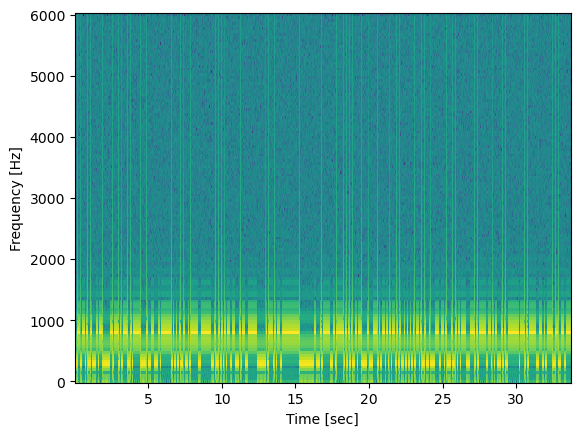

In [18]:
# Spectrogram of test.wav
import matplotlib.pyplot as plt
from scipy import signal

sample_rate, samples = wavfile.read('flag.wav')
f, t, Sxx = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(t, f, 10 * np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()